#  Apply LSTM to timeseries data forecasting


read the csv file into jupyter notebook. At first the column 'appliances' is imported as the univariate 

In [1]:
import pandas as pd
#read 'appliances' column into the dataframe
Dataframe = pd.read_csv('KAG_energydata_complete.csv',
                        index_col=[0],
                        usecols=[0, 1],
                        parse_dates=[0],
                        engine='python')
print(Dataframe.head())
dataset = Dataframe.values
dataset = dataset.astype('float32')

                     Appliances
date                           
2016-01-11 17:00:00          60
2016-01-11 17:10:00          60
2016-01-11 17:20:00          50
2016-01-11 17:30:00          50
2016-01-11 17:40:00          60


split the sequence into multiple input/output patterns given the time steps, the historical observations v(t-k)...v(t-1) is set as input,where k is the time steps. The output is the v(t) at next time step. In our model the time step is set to 1.

In [2]:
import numpy as np

def sequence_to_samples(sequence, stepsize):
    X, Y = [], []
    for i in range(len(sequence) - stepsize):
        a = sequence[i:(i + stepsize), 0]
        X.append(a)
        Y.append(sequence[i + stepsize, 0])
    return np.array(X), np.array(Y)

scale all the data to range (0,1) and split dataset into train/test dataset, the first 67% data is chosen as training data. Besides, the above function sequence_to_sample() is called to create samples 

In [3]:
from sklearn.preprocessing import MinMaxScaler
np.random.seed(520)
look_back = 1
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [4]:
trainx, trainy = sequence_to_samples(train, look_back)
testx, testy = sequence_to_samples(test, look_back)
print(trainx.shape, trainy.shape, testx.shape, testy.shape)

(13221, 1) (13221,) (6512, 1) (6512,)


due to the input structure requirement of LSTM: [samples, time_steps, features], the training data is reshaped 

In [5]:
trainx = np.reshape(trainx, (trainx.shape[0], 1, trainx.shape[1]))
testx = np.reshape(testx, (testx.shape[0], 1, testx.shape[1]))

before we design our lstm model, we should first initialize the LSTM units, activate function, iteration number. here we set LSTM univts to 256 and the iteration number to 20 since the loss function converges fast once the iteration starts. The default activate function is 'tanh' and we did not change it. 

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
model = Sequential()
model.add(LSTM(256, input_shape=(1, look_back)))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('tanh'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainx, trainy, epochs=20, batch_size=50, verbose=2)

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





 - 6s - loss: 0.0055
Epoch 2/20
 - 4s - loss: 0.0042
Epoch 3/20
 - 3s - loss: 0.0043
Epoch 4/20
 - 4s - loss: 0.0042
Epoch 5/20
 - 3s - loss: 0.0042
Epoch 6/20
 - 4s - loss: 0.0042
Epoch 7/20
 - 3s - loss: 0.0042
Epoch 8/20
 - 5s - loss: 0.0042
Epoch 9/20
 - 4s - loss: 0.0042
Epoch 10/20
 - 4s - loss: 0.0042
Epoch 11/20
 - 4s - loss: 0.0042
Epoch 12/20
 - 4s - loss: 0.0042
Epoch 13/20
 - 4s - loss: 0.0042
Epoch 14/20
 - 5s - loss: 0.0042
Epoch 15/20
 - 5s - loss: 0.0042
Epoch 16/20
 - 4s - loss: 0.0042
Epoch 17/20
 - 3s - loss: 0.0042
Epoch 18/20
 - 4s - loss: 0.0042
Epoch 19/20
 - 4s - loss: 0.0042
Epoch 20/20
 - 4s - loss: 0.0042


predict the test data and calculate the loss function. Mean square error of both train data and test data is shown as followed

In [7]:
trainpredict = model.predict(trainx)
testpredict = model.predict(testx)

In [8]:
trainpredict = scaler.inverse_transform(trainpredict)
trainy = scaler.inverse_transform([trainy])
testpredict = scaler.inverse_transform(testpredict)
testy = scaler.inverse_transform([testy])

In [9]:
import math
from sklearn.metrics import mean_squared_error

trainscore = math.sqrt(mean_squared_error(trainy[0], trainpredict[:, 0]))
print('Univariate LSTM Train Score: %.2f RMSE' % (trainscore))
testscore = math.sqrt(mean_squared_error(testy[0], testpredict[:, 0]))
print('Univariate LSTM Test Score: %.2f RMSE' % (testscore))

Univariate LSTM Train Score: 68.58 RMSE
Univariate LSTM Test Score: 63.46 RMSE


plot the predicted result and the label for camparison. 

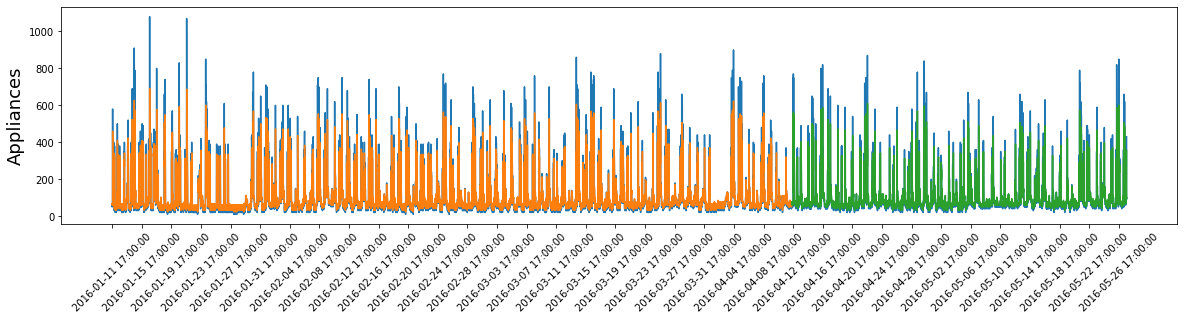

In [10]:
import matplotlib.pyplot as plt

trainpredictplot = np.empty_like(dataset)
trainpredictplot[:, :] = np.nan
trainpredictplot[look_back:len(trainpredict) + look_back, :] = trainpredict

testpredictplot = np.empty_like(dataset)
testpredictplot[:, :] = np.nan
testpredictplot[len(trainpredict) +
                (look_back * 2):len(dataset), :] = testpredict

plt.figure(figsize=(20, 4))
plt.plot(scaler.inverse_transform(dataset))
plt.xticks(range(0, dataset.shape[0], 576),
           Dataframe.index[::576],
           rotation=45)
plt.ylabel('Appliances',fontsize=18)
plt.plot(trainpredictplot)
plt.plot(testpredictplot)
plt.show()

From the above figure we could see that the forecasting result is not bad, but there is hugh deviation from actual value at peak point.The univariate LSTM only used one dimensional sequence as input data. In order to acquire better result and take best advantage of the given dataset. We designed another LSTM model to try multivariate LSTM

In [11]:
Dataframe = pd.read_csv('KAG_energydata_complete.csv',
                        header=0,
                        parse_dates=[0],
                        index_col=[0],
                        skipinitialspace=True)
print(Dataframe.head())
dataset = Dataframe.values
dataset = dataset.astype('float32')

                     Appliances  lights     T1       RH_1    T2       RH_2  \
date                                                                         
2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

                        T3       RH_3         T4       RH_4  ...         T9  \
date                                                         ...              
2016-01-11 17:00:00  19.79  44.730000  19.000000  45.566667  ...  17.033333   
2016-01-11 17:10:00  19.79  44.790000  19.000000  45.992500  ...  17.066667   
2016-01-11 17:20:00  19.79  44.933333  18.926667  45.890000  ...  17.000000   
2016-01-11 17:30:00  19.79  45.000000  18.890000  45.72333

The function 'sequence_to samples' is modified to adapt to multi-dimensional sequence.

In [12]:
def sequence_to_samples2(data, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    cols.append(df.shift(1))
    names += [('var%d(t-%d)' % (j + 1, 1)) for j in range(n_vars)]
    cols.append(df.shift(-0))
    names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

look_back = 1
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train = dataset[0:train_size, :]
test = dataset[train_size:len(dataset), :]
trainReframedDataset = sequence_to_samples2(train)
trainReframedDataset.drop(
    trainReframedDataset.iloc[:, look_back * dataset.shape[1] + 1:],
    inplace=True,
    axis=1)
testReframedDataset = sequence_to_samples2(test)
testReframedDataset.drop(
    testReframedDataset.iloc[:, look_back * dataset.shape[1] + 1:],
    inplace=True,
    axis=1)
print(trainReframedDataset.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.046729   0.428571   0.327349   0.566187   0.225345   0.684038   
2   0.046729   0.428571   0.327349   0.541326   0.225345   0.682140   
3   0.037383   0.428571   0.327349   0.530502   0.225345   0.679445   
4   0.037383   0.571429   0.327349   0.524080   0.225345   0.678414   
5   0.046729   0.571429   0.327349   0.531419   0.225345   0.676727   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var20(t-1)  var21(t-1)  \
1   0.215188   0.746066   0.351351    0.764262  ...    0.677290    0.372990   
2   0.215188   0.748871   0.351351    0.782437  ...    0.678532    0.369239   
3   0.215188   0.755569   0.344745    0.778062  ...    0.676049    0.365488   
4   0.215188   0.758685   0.341441    0.770949  ...    0.671909    0.361736   
5   0.215188   0.758685   0.341441    0.762697  ...    0.671909    0.357985   

   var22(t-1)  var23(t-1)  var24(t-1)  var25(t-1)  var26(t-1)  var27(t-1)  \
1    0.097675    0.89

split the train/test dataset as before and fit LSTM model with historical observations v1(t-1)……v28(t-1). The predicted result is plotted and mean square error is calculated. The enhancement of result is observed. 

In [13]:
trainReframedDataset = trainReframedDataset.values
testReframedDataset = testReframedDataset.values

trainx, trainy = trainReframedDataset[:, :-1], trainReframedDataset[:, -1]
testx, testy = testReframedDataset[:, :-1], testReframedDataset[:, -1]

trainx = trainx.reshape((trainx.shape[0], 1, trainx.shape[1]))
testx = testx.reshape((testx.shape[0], 1, testx.shape[1]))
print(trainx.shape, trainy.shape, testx.shape, testy.shape)

(13221, 1, 28) (13221,) (6512, 1, 28) (6512,)


In [14]:
model = Sequential()
model.add(LSTM(256, input_shape=(trainx.shape[1], trainx.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('tanh'))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainx, trainy, epochs=20, batch_size=50, verbose=2)
trainpredict = model.predict(trainx)
testpredict = model.predict(testx)

Epoch 1/20
 - 7s - loss: 0.0061
Epoch 2/20
 - 4s - loss: 0.0046
Epoch 3/20
 - 4s - loss: 0.0045
Epoch 4/20
 - 4s - loss: 0.0045
Epoch 5/20
 - 4s - loss: 0.0044
Epoch 6/20
 - 4s - loss: 0.0044
Epoch 7/20
 - 6s - loss: 0.0043
Epoch 8/20
 - 4s - loss: 0.0044
Epoch 9/20
 - 4s - loss: 0.0043
Epoch 10/20
 - 4s - loss: 0.0043
Epoch 11/20
 - 5s - loss: 0.0043
Epoch 12/20
 - 4s - loss: 0.0043
Epoch 13/20
 - 4s - loss: 0.0042
Epoch 14/20
 - 5s - loss: 0.0042
Epoch 15/20
 - 5s - loss: 0.0043
Epoch 16/20
 - 5s - loss: 0.0043
Epoch 17/20
 - 6s - loss: 0.0042
Epoch 18/20
 - 9s - loss: 0.0042
Epoch 19/20
 - 6s - loss: 0.0042
Epoch 20/20
 - 12s - loss: 0.0042


In [15]:
testx = testx.reshape((testx.shape[0], testx.shape[2]))
testpredict = np.concatenate((testpredict, testx[:, 1:]), axis=1)
testpredict = scaler.inverse_transform(testpredict)
testpredict = testpredict[:, 0]

trainx = trainx.reshape((trainx.shape[0], trainx.shape[2]))
trainpredict = np.concatenate((trainpredict, trainx[:, 1:]), axis=1)
trainpredict = scaler.inverse_transform(trainpredict)
trainpredict = trainpredict[:, 0]

trainy = scaler.inverse_transform(trainx)[:, 0]
testy = scaler.inverse_transform(testx)[:, 0]
trainscore = math.sqrt(mean_squared_error(trainy, trainpredict))
print('Multivariate LSTM Train Score: %.2f RMSE' % (trainscore))
testscore = math.sqrt(mean_squared_error(testy, testpredict))
print('Multivariate LSTM Test Score: %.2f RMSE' % (testscore))

Multivariate LSTM Train Score: 27.32 RMSE
Multivariate LSTM Test Score: 30.05 RMSE


Compared to the univariate LSTM, the mean square error is reduced by half and the forecasting works better at peak point. 

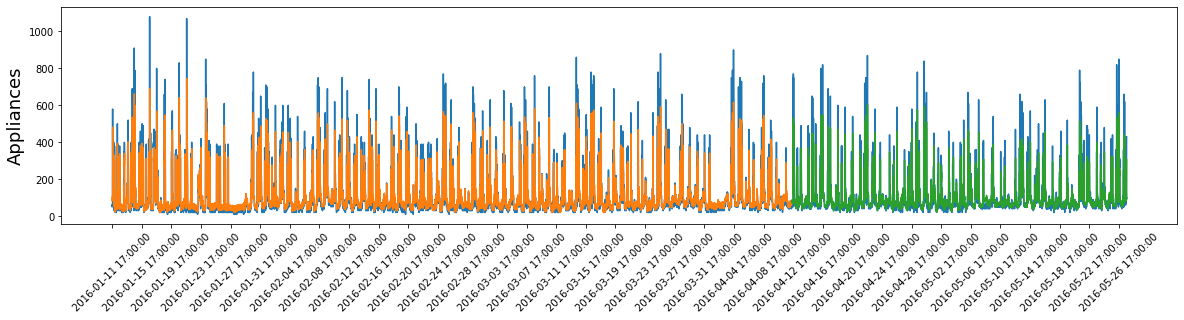

In [16]:
trainpredictplot = np.empty_like(dataset[:, 0])
trainpredictplot[:] = np.nan
trainpredictplot[look_back:len(trainpredict) + look_back] = trainpredict

testpredictplot = np.empty_like(dataset[:, 0])
testpredictplot[:] = np.nan
testpredictplot[len(trainpredict) + (look_back * 2):len(dataset)] = testpredict
plt.figure(figsize=(20, 4))
plt.plot(scaler.inverse_transform(dataset)[:, 0])
plt.xticks(range(0, dataset.shape[0], 576),
           Dataframe.index[::576],
           rotation=45)
plt.ylabel('Appliances',fontsize=18)
plt.plot(trainpredictplot)
plt.plot(testpredictplot)
plt.show()